Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [49]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
surface_files = [
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in surface_files:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

In [83]:
droot = f"{config.project_tmpdir}/simulation-data/MIROC4-ACTM_T42"

path = f"{droot}/{obspack_files['cba'].replace('.nc', '.txt')[4:]}"
print(path)
df = pd.read_csv(path, delim_whitespace=True, header=1, na_values=-599.0000)
df = df.rename({'Year': 'year', 'MM': 'month', 'DD': 'day', 'HH': 'hour', 'MI': 'minute'}, axis=1)

df['time'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('time')
df = df.dropna()
df

/glade/work/stephens/sno-analysis/simulation-data/MIROC4-ACTM_T42/cba_surface-flask_4_representative.txt


,year,month,day,hour,minute,IS,DoY,UTC,Obs_Lat,Obs_Lon,...,co2_oco2mip,co2_cesm,co2_somffn,n2_cesm,n2_era,o2_gridfed,o2_cesm,o2_gk01r16,CO2actm_gc3t,CO2obs
time,,,,,,,,,,,,,,,,,,,,,
1995-08-16,1995,8,16,20,30,0,228,73800,55.21,-162.72,...,426.1560,387.9341,393.0640,403.3712,415.2585,358.3427,411.2146,412.6761,-3668.9961,351.7046
1995-08-18,1995,8,18,0,30,0,230,1800,55.21,-162.72,...,426.5935,388.0025,392.5504,401.4902,414.0329,357.5119,406.9485,409.9182,-3668.9961,349.6950
1995-08-24,1995,8,24,19,0,0,236,68400,55.21,-162.72,...,426.2491,388.8099,393.2707,397.3512,409.4680,358.2004,404.2099,404.6645,-3668.9961,350.9048
1995-09-08,1995,9,8,21,30,0,251,77400,55.21,-162.72,...,426.4702,388.8102,393.0586,398.2094,410.2551,357.7890,407.9724,404.9661,-3668.9961,352.6643
1995-10-05,1995,10,5,22,30,0,278,81000,55.21,-162.72,...,427.3359,388.1405,392.9031,395.4085,407.5588,356.6567,407.8593,399.8958,-3668.9961,359.4017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,2020,8,27,20,55,0,240,75300,55.21,-162.72,...,524.2774,355.0305,370.0568,385.5140,418.1548,221.0111,431.4303,408.1286,400.1620,401.0247
2020-10-01,2020,10,1,21,45,0,275,78300,55.21,-162.72,...,524.7364,355.7531,371.0544,380.7482,412.7712,220.4865,425.3008,402.1424,411.2572,413.0811
2020-10-15,2020,10,15,21,35,0,289,77700,55.21,-162.72,...,524.8640,355.8274,371.3362,379.4320,411.6947,220.3076,423.0297,400.7096,413.5142,414.2585


In [84]:
# add derived APO variables

df['apo_cesm'] = util.compute_apo (
    o2=df['o2_cesm'],
    co2=df['co2_cesm'],
    n2=df['n2_cesm']
)

df['apo_diss'] = util.compute_apo (
    o2=df['o2_gk01r16'],
    co2=df['co2_somffn'],
    n2=df['n2_era']
)

df['apo_gridfed'] = util.compute_apo (
    o2=df['o2_gridfed'],
    co2=df['co2_gridfed'],
    n2=0.0
)

df['apo_oco2mip'] = util.compute_apo (
    o2=df['co2_oco2mip'] * -1.4,
    co2=df['co2_oco2mip'],
    n2=0.0
)

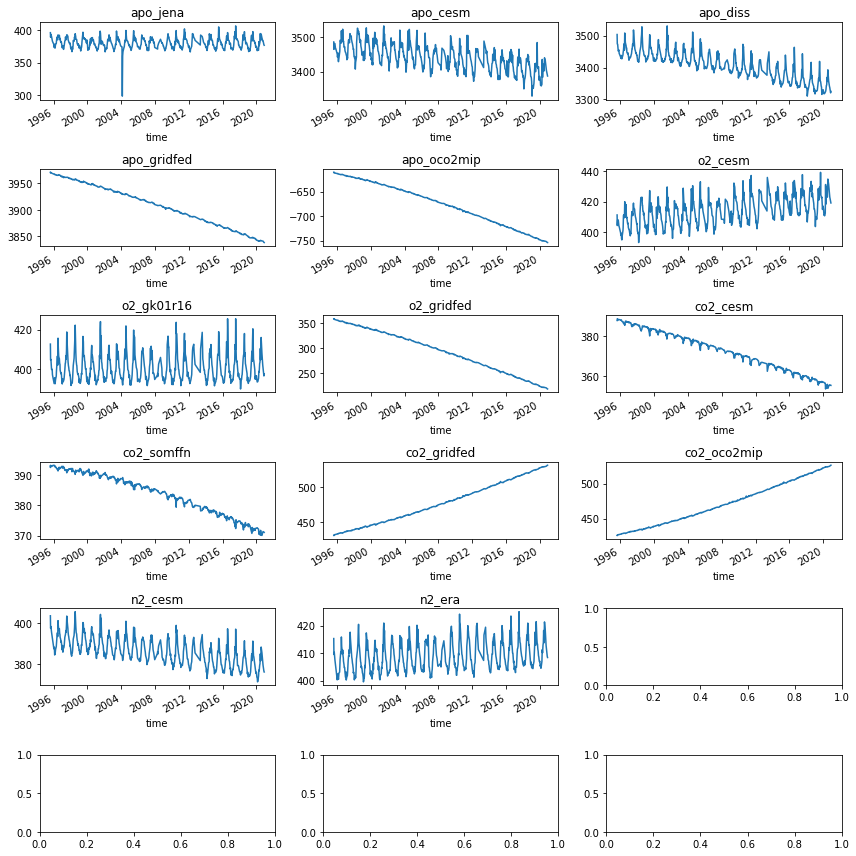

In [85]:
sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    df[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, n_plots):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

In [86]:
ds = df.to_xarray()
ds

<xarray.Dataset>
Dimensions:       (time: 553)
Coordinates:
  * time          (time) datetime64[ns] 1995-08-16 1995-08-18 ... 2020-12-03
Data variables: (12/27)
    year          (time) int64 1995 1995 1995 1995 1995 ... 2020 2020 2020 2020
    month         (time) int64 8 8 8 9 10 11 11 1 1 2 ... 6 6 7 7 8 10 10 11 12
    day           (time) int64 16 18 24 8 5 1 13 13 25 ... 18 2 24 27 1 15 20 3
    hour          (time) int64 20 0 19 21 22 21 18 23 ... 19 21 20 21 21 21 22
    minute        (time) int64 30 30 0 30 30 40 50 30 ... 50 55 55 45 35 55 40
    IS            (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ...            ...
    CO2actm_gc3t  (time) float64 -3.669e+03 -3.669e+03 ... 418.9 418.5
    CO2obs        (time) float64 351.7 349.7 350.9 352.7 ... 414.3 418.8 419.4
    apo_cesm      (time) float64 3.485e+03 3.467e+03 ... 3.391e+03 3.387e+03
    apo_diss      (time) float64 3.504e+03 3.489e+03 ... 3.32e+03 3.325e+03
    apo_gridfed   (time) float64 3.971e+03 3.97e+03 ... 3.839e+03 3.838e+03
    apo_oco2mip   (time) float64 -610.5 -611.2 -610.7 ... -752.0 -753.7 -753.9

In [87]:
ds_seas=ds.groupby('time.month').mean('time')
ds_seas['apo_cesm']

<xarray.DataArray 'apo_cesm' (month: 12)>
array([3416.8052904 , 3410.54558117, 3402.98046121, 3415.86375636,
       3451.65114415, 3469.74580801, 3469.2496742 , 3466.56059264,
       3466.75502193, 3455.03205875, 3440.60020452, 3425.18929795])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

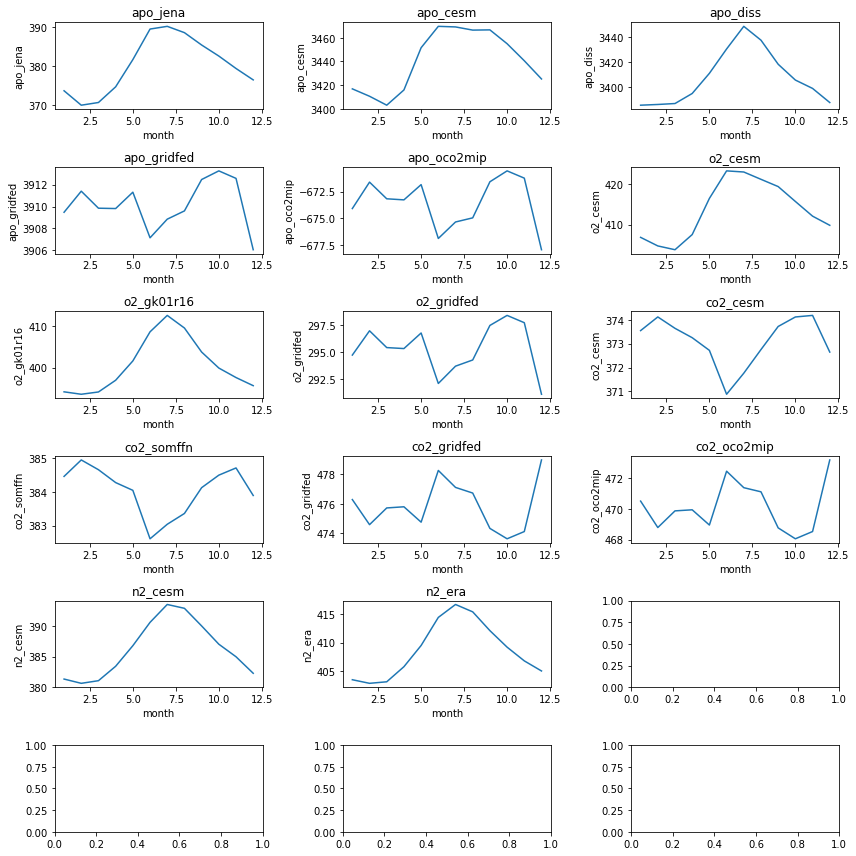

In [88]:
# seasonal climatology
ds_seas=ds.groupby('time.month').mean('time')
ds_seas['apo_cesm']

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds_seas[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, n_plots):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

### to do:
- pull request
- add PSA to existing plots
- 4-panel timeseries plot of derived APOs with contributions
- 4-panel seasonal plot of derived APOs with contributions
- 2-panel plot comparing all 5 APOs for both CBA and PSA
- binned mean aircraft cross-sections
- binned harmonic amplitude aircraft cross-sections
- individual campaign segment cross-sections and curtain averages (use existing R for now?)
- observed cross-sections compared to (and subtracted from) integrated fluxes
- same for other ingests
- multimodel comparison notebook
